In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, GRU, Bidirectional, Dense, Attention, Dropout
from keras.callbacks import EarlyStopping
import os


In [6]:


# Combine all participant data
all_data = []
for participant in range(1, 5):
    for file_num in range(1, 11):
        file_path = f"EDA_{participant}_{file_num}.csv"
        df = pd.read_csv(file_path, skiprows=3, header=None, names=['EDA'])
        all_data.append(df)

# Concatenate all the data files into one dataframe
combined_data = pd.concat(all_data, ignore_index=True)
combined_data.reset_index(drop=True, inplace=True)


In [9]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_filter(data, filter_type='low', cutoff=0.05, fs=4, order=4):
    if filter_type == 'low':
        b, a = butter_lowpass(cutoff, fs, order)
    else:
        b, a = butter_highpass(cutoff, fs, order)
    y = filtfilt(b, a, data)
    return y

def extract_phasic_tonic_manual(eda_signal, fs=4):
    tonic_component = apply_filter(eda_signal, filter_type='low', cutoff=0.05, fs=fs)
    phasic_component = apply_filter(eda_signal - tonic_component, filter_type='high', cutoff=0.05, fs=fs)
    return phasic_component, tonic_component

In [10]:
# Assuming 'combined_data' has been loaded as described before
eda_signal = combined_data['EDA'].values
phasic_data, tonic_data = extract_phasic_tonic_manual(eda_signal)

# Add these components to your dataframe
combined_data['Phasic'] = phasic_data
combined_data['Tonic'] = tonic_data


In [11]:
def split_data(data, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(combined_data)


In [12]:
scaler_phasic = MinMaxScaler()
scaler_tonic = MinMaxScaler()

train_data['Phasic'] = scaler_phasic.fit_transform(train_data['Phasic'].values.reshape(-1, 1))
train_data['Tonic'] = scaler_tonic.fit_transform(train_data['Tonic'].values.reshape(-1, 1))

val_data['Phasic'] = scaler_phasic.transform(val_data['Phasic'].values.reshape(-1, 1))
val_data['Tonic'] = scaler_tonic.transform(val_data['Tonic'].values.reshape(-1, 1))

test_data['Phasic'] = scaler_phasic.transform(test_data['Phasic'].values.reshape(-1, 1))
test_data['Tonic'] = scaler_tonic.transform(test_data['Tonic'].values.reshape(-1, 1))


<ipython-input-12-9b8815f41c8c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Phasic'] = scaler_phasic.fit_transform(train_data['Phasic'].values.reshape(-1, 1))
<ipython-input-12-9b8815f41c8c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Tonic'] = scaler_tonic.fit_transform(train_data['Tonic'].values.reshape(-1, 1))
<ipython-input-12-9b8815f41c8c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [13]:
def create_sequences(data, seq_length=50):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[['Phasic', 'Tonic']].iloc[i:i + seq_length].values)
        y.append(data[['Phasic', 'Tonic']].iloc[i + seq_length].values)
    return np.array(x), np.array(y)

X_train, y_train = create_sequences(train_data)
X_val, y_val = create_sequences(val_data)
X_test, y_test = create_sequences(test_data)


In [14]:
model_lstm = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(2)
])

model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 2/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 9.1446e-05 - val_loss: 0.0010
Epoch 3/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 7.1937e-05 - val_loss: 8.4874e-04
Epoch 4/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 6.8986e-05 - val_loss: 5.9793e-04
Epoch 5/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - loss: 5.8035e-05 - val_loss: 9.1933e-04
Epoch 6/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 4.9120e-05 - val_loss: 5.6833e-04
Epoch 7/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 4.1181e-05 - val_loss: 3.1370e-04
Epoch 8/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 3.6942e-05 - val_loss: 4.2246e-04
Epoch 9/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 4.7376e-05 - val_loss: 7.5589e-04
Epoch 10/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 3.8843e-05 - val_loss: 4.7719e-04
Epoch 11/50
1112/1112 ━━━━━━━━━

In [15]:
model_gru = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(2)
])

model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Epoch 1/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - loss: 0.0054 - val_loss: 9.3415e-04
Epoch 2/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - loss: 4.9461e-05 - val_loss: 9.5760e-04
Epoch 3/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - loss: 6.1714e-05 - val_loss: 9.2575e-04
Epoch 4/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - loss: 3.8358e-05 - val_loss: 5.0642e-04
Epoch 5/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 4.4596e-05 - val_loss: 3.8805e-04
Epoch 6/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - loss: 4.1203e-05 - val_loss: 2.7066e-04
Epoch 7/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - loss: 3.5695e-05 - val_loss: 2.5711e-04
Epoch 8/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 3.3675e-05 - val_loss: 2.5062e-04
Epoch 9/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - loss: 3.5728e-05 - val_loss: 2.5104e-04
Epoch 10/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - loss: 3.3211e-05 - val_loss: 2.8619e-04
Epoch 11/50
1112/1112 ━

In [16]:
model_bilstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)
])

model_bilstm.compile(optimizer='adam', loss='mse')
history_bilstm = model_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1112/1112 ━━━━━━━━━━━━━━━━━━━━ 65s 55ms/step - loss: 0.0040 - val_loss: 6.8673e-04
Epoch 2/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - loss: 8.0140e-05 - val_loss: 0.0011
Epoch 3/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 84s 57ms/step - loss: 7.9041e-05 - val_loss: 9.5179e-04
Epoch 4/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 60s 54ms/step - loss: 6.6429e-05 - val_loss: 7.4364e-04
Epoch 5/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step - loss: 4.8659e-05 - val_loss: 4.7368e-04
Epoch 6/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 61s 55ms/step - loss: 4.4466e-05 - val_loss: 0.0011
Epoch 7/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 4.6598e-05 - val_loss: 0.0025
Epoch 8/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 4.3572e-05 - val_loss: 4.5686e-04
Epoch 9/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 59s 53ms/step - loss: 4.1913e-05 - val_loss: 0.0011
Epoch 10/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 3.1031e-05 - val_loss: 3.1019e-04
Epoch 11/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 54m

In [25]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    return rmse, mae

metrics_lstm = evaluate_model(model_lstm, X_test, y_test)
metrics_gru = evaluate_model(model_gru, X_test, y_test)
metrics_bilstm = evaluate_model(model_bilstm, X_test, y_test)
# metrics_attention = evaluate_model(model_attention, X_test, y_test)


476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step


In [26]:
print("LSTM Metrics:")
print("RMSE:", metrics_lstm[0])
print("MAE:", metrics_lstm[1])

print("\nGRU Metrics:")
print("RMSE:", metrics_gru[0])
print("MAE:", metrics_gru[1])

print("\nBiLSTM Metrics:")
print("RMSE:", metrics_bilstm[0])
print("MAE:", metrics_bilstm[1])

LSTM Metrics:
RMSE: 0.02521766804048019
MAE: 0.008995364758499283

GRU Metrics:
RMSE: 0.02270158905028775
MAE: 0.006402537778779246

BiLSTM Metrics:
RMSE: 0.02374594569464978
MAE: 0.010451485472666448


In [32]:
# Make predictions using the trained models
predictions_lstm = model_lstm.predict(X_test)
predictions_gru = model_gru.predict(X_test)
predictions_bilstm = model_bilstm.predict(X_test)



476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step


In [33]:
# Inverse transform the predictions and actual values for phasic and tonic components
y_test_phasic = scaler_phasic.inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_tonic = scaler_tonic.inverse_transform(y_test[:, 1].reshape(-1, 1))

predictions_lstm_phasic = scaler_phasic.inverse_transform(predictions_lstm[:, 0].reshape(-1, 1))
predictions_lstm_tonic = scaler_tonic.inverse_transform(predictions_lstm[:, 1].reshape(-1, 1))

predictions_gru_phasic = scaler_phasic.inverse_transform(predictions_gru[:, 0].reshape(-1, 1))
predictions_gru_tonic = scaler_tonic.inverse_transform(predictions_gru[:, 1].reshape(-1, 1))

predictions_bilstm_phasic = scaler_phasic.inverse_transform(predictions_bilstm[:, 0].reshape(-1, 1))
predictions_bilstm_tonic = scaler_tonic.inverse_transform(predictions_bilstm[:, 1].reshape(-1, 1))


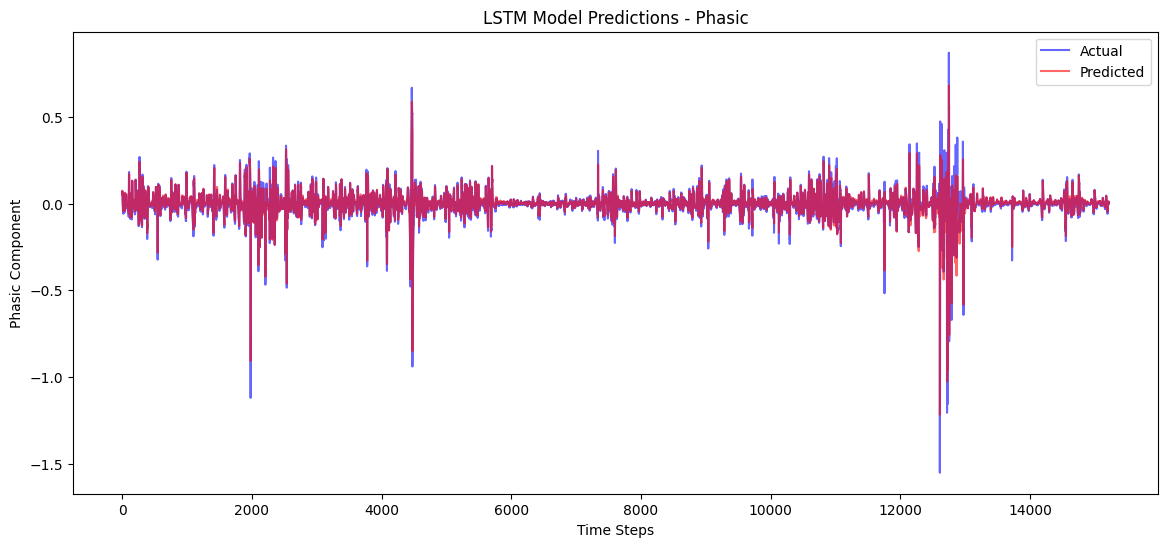

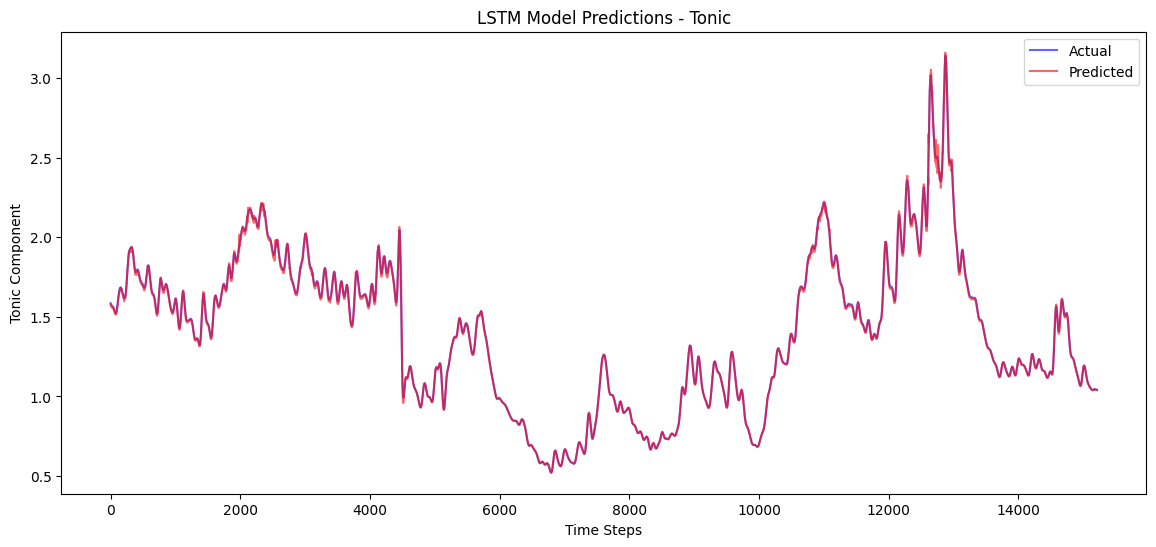

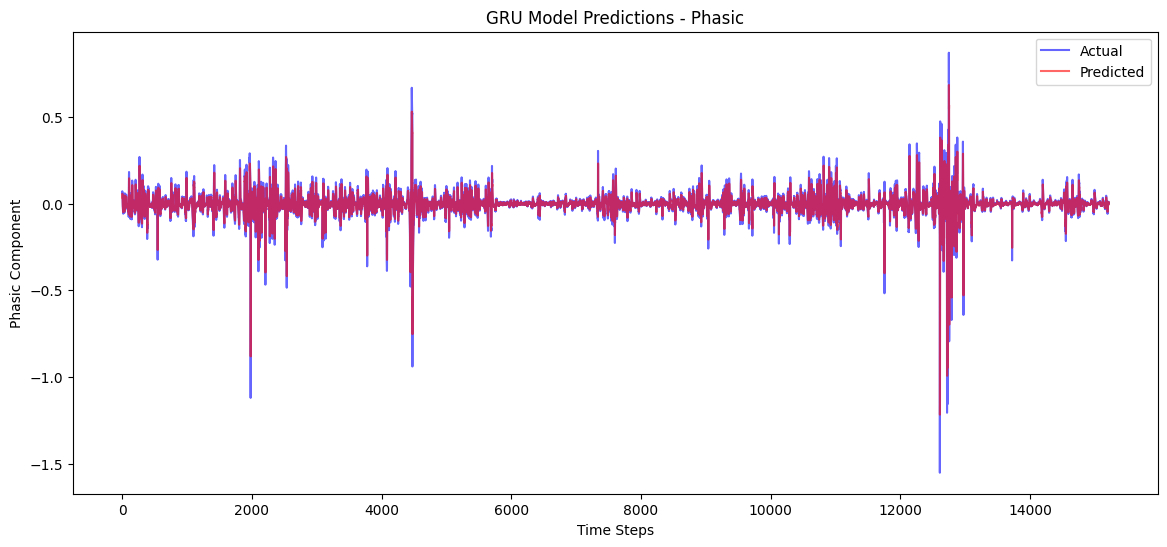

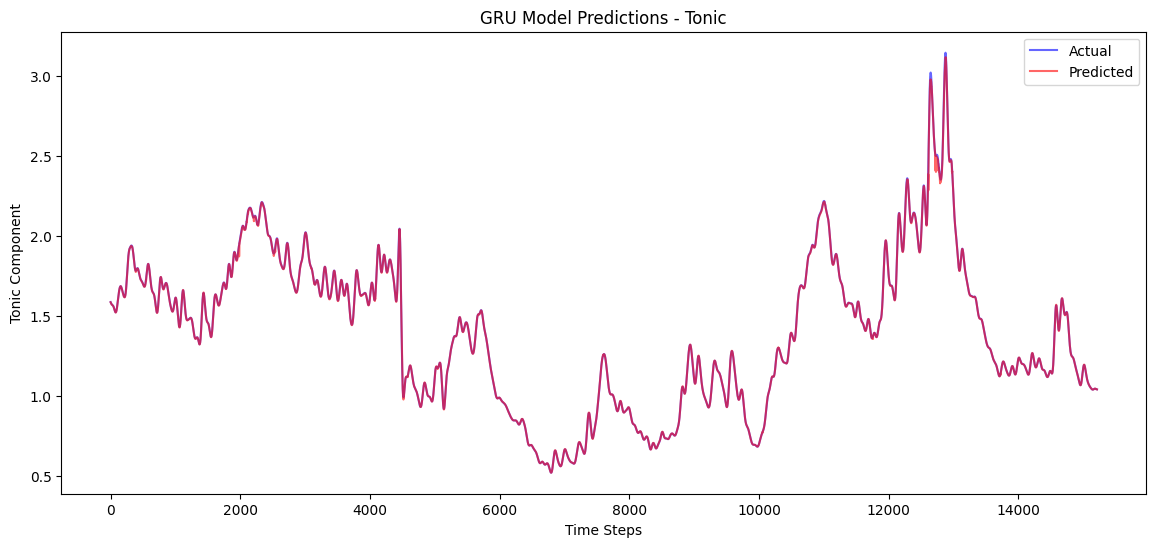

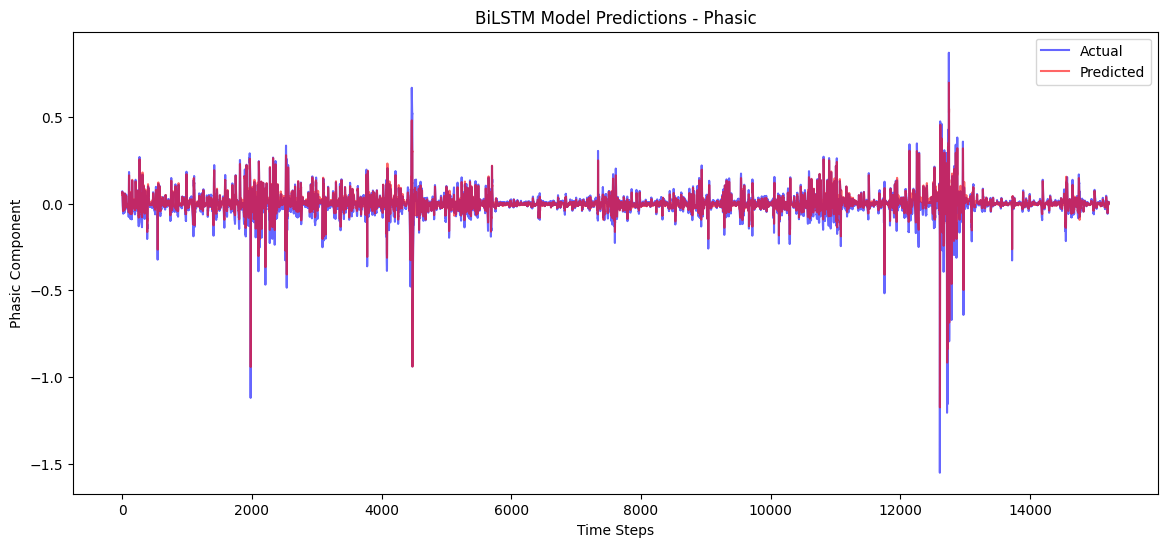

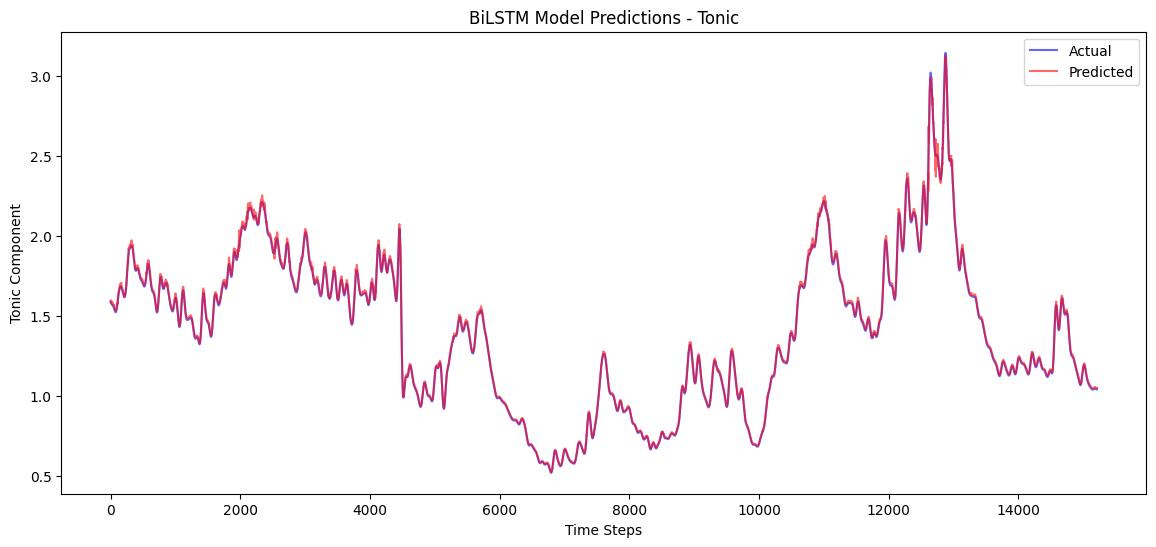

In [34]:
import matplotlib.pyplot as plt

# Define a function to plot predictions vs. actuals
def plot_predictions(actual, predicted, title, component_name):
    plt.figure(figsize=(14, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.6)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.6)
    plt.title(f"{title} - {component_name}")
    plt.xlabel('Time Steps')
    plt.ylabel(f'{component_name} Component')
    plt.legend()
    plt.show()

# Visualize Phasic Component Predictions for LSTM
plot_predictions(y_test_phasic, predictions_lstm_phasic, "LSTM Model Predictions", "Phasic")

# Visualize Tonic Component Predictions for LSTM
plot_predictions(y_test_tonic, predictions_lstm_tonic, "LSTM Model Predictions", "Tonic")

# Visualize Phasic Component Predictions for GRU
plot_predictions(y_test_phasic, predictions_gru_phasic, "GRU Model Predictions", "Phasic")

# Visualize Tonic Component Predictions for GRU
plot_predictions(y_test_tonic, predictions_gru_tonic, "GRU Model Predictions", "Tonic")

# Visualize Phasic Component Predictions for BiLSTM
plot_predictions(y_test_phasic, predictions_bilstm_phasic, "BiLSTM Model Predictions", "Phasic")

# Visualize Tonic Component Predictions for BiLSTM
plot_predictions(y_test_tonic, predictions_bilstm_tonic, "BiLSTM Model Predictions", "Tonic")


In [48]:
# Load the new external test data file
new_data = pd.read_csv('EDA_Testing.csv', skiprows=3, header=None, names=['EDA'])

# Extract phasic and tonic components using the same manual method as before
eda_signal = new_data['EDA'].values
phasic_data, tonic_data = extract_phasic_tonic_manual(eda_signal)

# Add the components to the dataframe
new_data['Phasic'] = phasic_data
new_data['Tonic'] = tonic_data


In [49]:
# Determine the split index
split_index = int(len(new_data) * 0.8)

# Split into 80% training and 20% for testing
new_train_data = new_data[:split_index]
new_test_data = new_data[split_index:]


In [50]:
# Use the previously fitted scalers to normalize the new data
new_train_data['Phasic'] = scaler_phasic.transform(new_train_data['Phasic'].values.reshape(-1, 1))
new_train_data['Tonic'] = scaler_tonic.transform(new_train_data['Tonic'].values.reshape(-1, 1))

new_test_data['Phasic'] = scaler_phasic.transform(new_test_data['Phasic'].values.reshape(-1, 1))
new_test_data['Tonic'] = scaler_tonic.transform(new_test_data['Tonic'].values.reshape(-1, 1))


<ipython-input-50-be4319283756>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_data['Phasic'] = scaler_phasic.transform(new_train_data['Phasic'].values.reshape(-1, 1))
<ipython-input-50-be4319283756>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_data['Tonic'] = scaler_tonic.transform(new_train_data['Tonic'].values.reshape(-1, 1))
<ipython-input-50-be4319283756>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [51]:
# Create sequences for the new train data (80%)
X_new_train, y_new_train = create_sequences(new_train_data, seq_length=50)

# Create sequences for the new test data (20%) for comparison
X_new_test, y_new_test = create_sequences(new_test_data, seq_length=50)


In [52]:
# Make predictions using the trained models
predictions_lstm_new = model_lstm.predict(X_new_test)
predictions_gru_new = model_gru.predict(X_new_test)
predictions_bilstm_new = model_bilstm.predict(X_new_test)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [53]:
# Inverse transform the predictions and actual values for phasic and tonic components
y_new_test_phasic = scaler_phasic.inverse_transform(y_new_test[:, 0].reshape(-1, 1))
y_new_test_tonic = scaler_tonic.inverse_transform(y_new_test[:, 1].reshape(-1, 1))

predictions_lstm_new_phasic = scaler_phasic.inverse_transform(predictions_lstm_new[:, 0].reshape(-1, 1))
predictions_lstm_new_tonic = scaler_tonic.inverse_transform(predictions_lstm_new[:, 1].reshape(-1, 1))

predictions_gru_new_phasic = scaler_phasic.inverse_transform(predictions_gru_new[:, 0].reshape(-1, 1))
predictions_gru_new_tonic = scaler_tonic.inverse_transform(predictions_gru_new[:, 1].reshape(-1, 1))

predictions_bilstm_new_phasic = scaler_phasic.inverse_transform(predictions_bilstm_new[:, 0].reshape(-1, 1))
predictions_bilstm_new_tonic = scaler_tonic.inverse_transform(predictions_bilstm_new[:, 1].reshape(-1, 1))


In [54]:
def evaluate_new_model(actual_phasic, predicted_phasic, actual_tonic, predicted_tonic):
    rmse_phasic = np.sqrt(mean_squared_error(actual_phasic, predicted_phasic))
    rmse_tonic = np.sqrt(mean_squared_error(actual_tonic, predicted_tonic))

    mae_phasic = mean_absolute_error(actual_phasic, predicted_phasic)
    mae_tonic = mean_absolute_error(actual_tonic, predicted_tonic)

    return {'Phasic RMSE': rmse_phasic, 'Tonic RMSE': rmse_tonic,
            'Phasic MAE': mae_phasic, 'Tonic MAE': mae_tonic}

metrics_lstm_new = evaluate_new_model(y_new_test_phasic, predictions_lstm_new_phasic, y_new_test_tonic, predictions_lstm_new_tonic)
metrics_gru_new = evaluate_new_model(y_new_test_phasic, predictions_gru_new_phasic, y_new_test_tonic, predictions_gru_new_tonic)
metrics_bilstm_new = evaluate_new_model(y_new_test_phasic, predictions_bilstm_new_phasic, y_new_test_tonic, predictions_bilstm_new_tonic)

print("LSTM on New Data:", metrics_lstm_new)
print("GRU on New Data:", metrics_gru_new)
print("BiLSTM on New Data:", metrics_bilstm_new)


LSTM on New Data: {'Phasic RMSE': 0.0027935519530168287, 'Tonic RMSE': 0.0007187244083372319, 'Phasic MAE': 0.0022809174886078525, 'Tonic MAE': 0.0007128845215155479}
GRU on New Data: {'Phasic RMSE': 0.003007710917391131, 'Tonic RMSE': 0.0003810207502493973, 'Phasic MAE': 0.002449326506955803, 'Tonic MAE': 0.00037401243625551496}
BiLSTM on New Data: {'Phasic RMSE': 0.004520668690709006, 'Tonic RMSE': 0.005699827587376212, 'Phasic MAE': 0.003759282270452226, 'Tonic MAE': 0.005696954794522211}


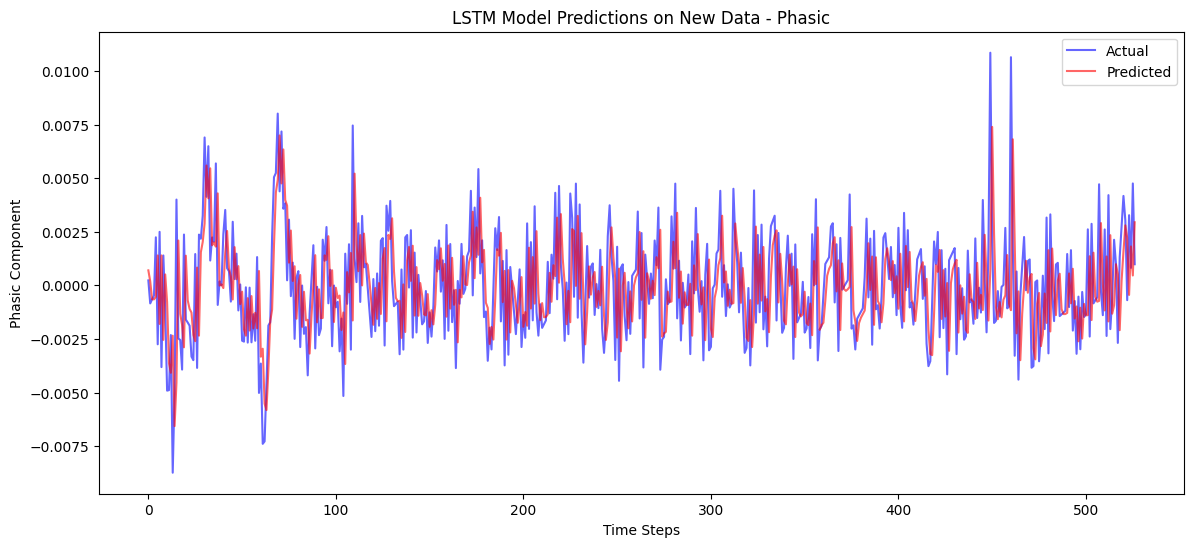

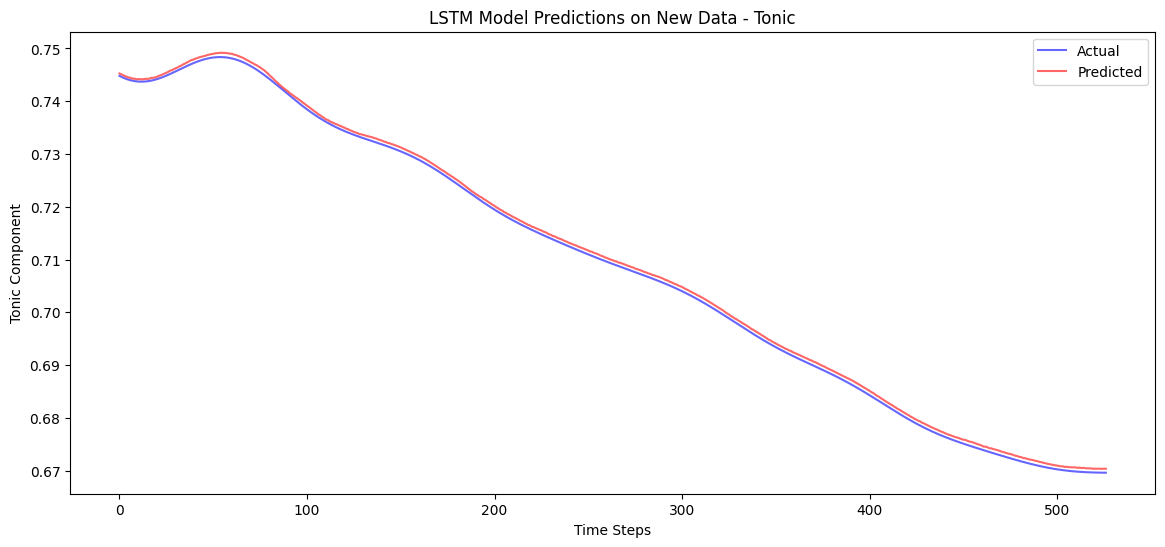

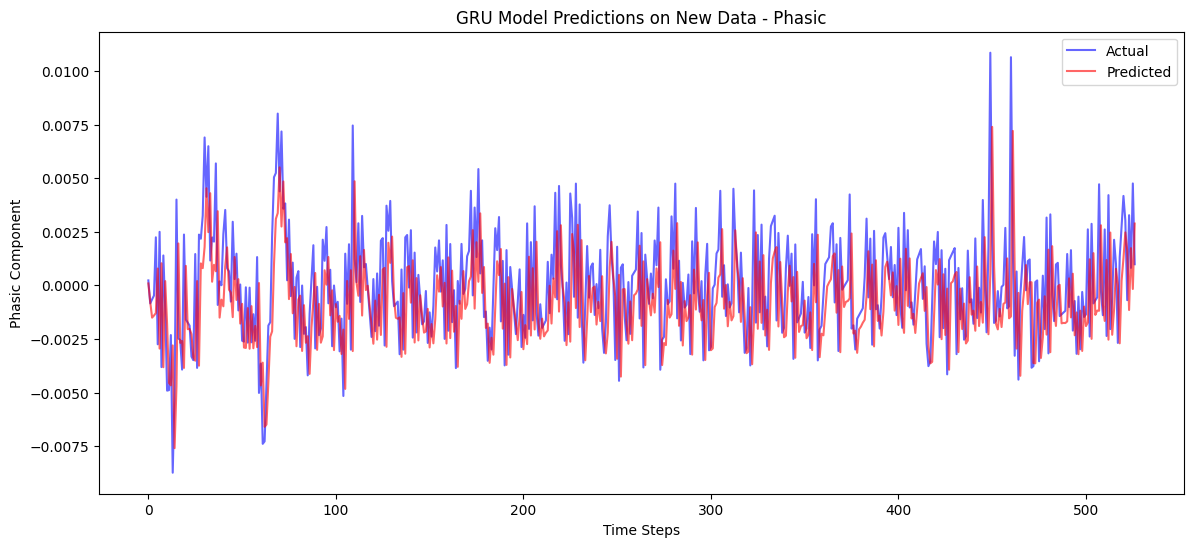

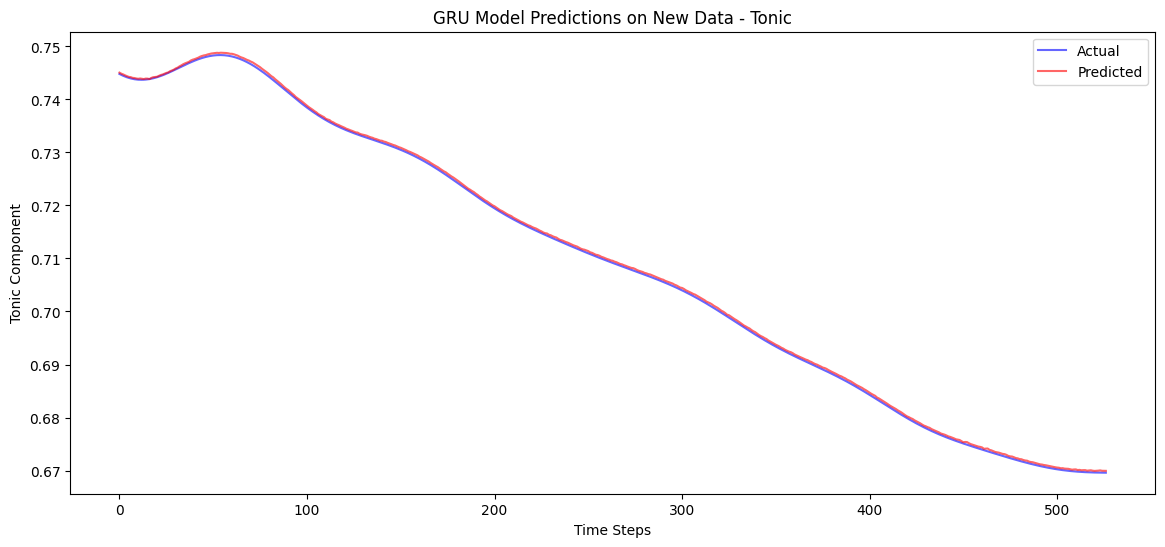

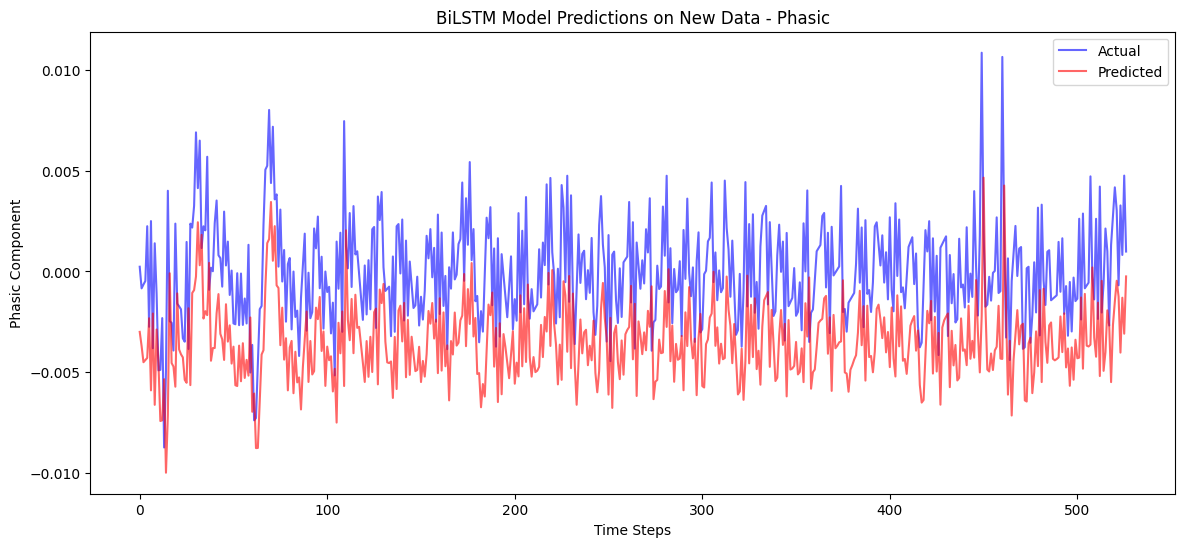

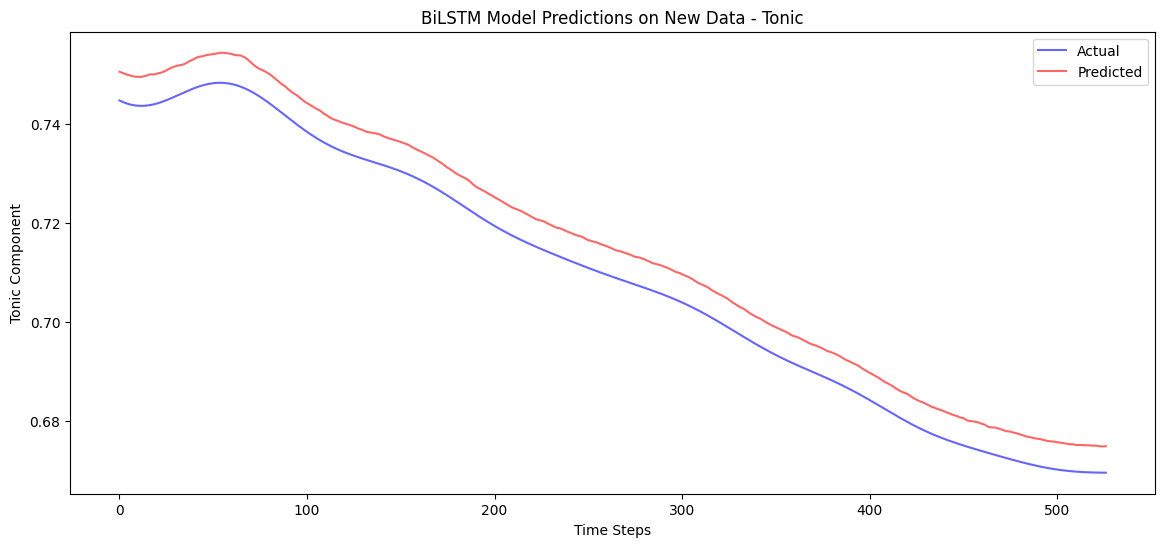

In [55]:
# Plot the predictions against the actual values
def plot_predictions_new(actual, predicted, title, component_name):
    plt.figure(figsize=(14, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.6)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.6)
    plt.title(f"{title} - {component_name}")
    plt.xlabel('Time Steps')
    plt.ylabel(f'{component_name} Component')
    plt.legend()
    plt.show()

# Visualize Phasic Component Predictions for LSTM
plot_predictions_new(y_new_test_phasic, predictions_lstm_new_phasic, "LSTM Model Predictions on New Data", "Phasic")

# Visualize Tonic Component Predictions for LSTM
plot_predictions_new(y_new_test_tonic, predictions_lstm_new_tonic, "LSTM Model Predictions on New Data", "Tonic")

# Visualize Phasic Component Predictions for GRU
plot_predictions_new(y_new_test_phasic, predictions_gru_new_phasic, "GRU Model Predictions on New Data", "Phasic")

# Visualize Tonic Component Predictions for GRU
plot_predictions_new(y_new_test_tonic, predictions_gru_new_tonic, "GRU Model Predictions on New Data", "Tonic")

# Visualize Phasic Component Predictions for BiLSTM
plot_predictions_new(y_new_test_phasic, predictions_bilstm_new_phasic, "BiLSTM Model Predictions on New Data", "Phasic")

# Visualize Tonic Component Predictions for BiLSTM
plot_predictions_new(y_new_test_tonic, predictions_bilstm_new_tonic, "BiLSTM Model Predictions on New Data", "Tonic")
